# 02 – Sanity Checks (Library Borrowings)

**Purpose:** Validate internal consistency and plausibility of the merged borrowing dataset before any analysis.

This notebook:
- parses key fields (timestamps, numeric columns),
- runs consistency checks (dates, durations, lateness, identifiers),
- summarizes the number and share of affected records.

**Not included:**
- no filtering, no dropping rows,
- no interpretation of causes.

Cleaning decisions will be made in the next notebook (`03_data_cleaning.ipynb`).

In [69]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["axes.prop_cycle"] = cycler(color=["#a51e36"])

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [70]:
# --- load data ---
PROCESSED_DATA_PATH = Path('../data/processed')
DATA_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025.csv" 

borrowings = pd.read_csv(
    DATA_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2407610, 17)


In [ ]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
RETURN_COL = "Rückgabedatum/Uhrzeit"

DURATION_COL = "Leihdauer"
EXT_COL = "Anzahl_Verlängerungen"
LATE_FLAG_COL = "Verspätet"
LATE_DAYS_COL = "Tage_zu_spät"

ID_COL = "issue_id"
USER_COL = "Benutzer-Systemnummer"
BARCODE_COL = "Barcode"

# timestamps
for c in [ISSUE_COL, RETURN_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_datetime(borrowings[c], errors="coerce")

# numeric columns
for c in [DURATION_COL, EXT_COL, LATE_DAYS_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_numeric(borrowings[c], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")


The following function is a helper for logging upcoming issues in the sanity checking process.

In [72]:
# --- define issue logging function ---
issues = []

def log_issue(name: str, mask: pd.Series):
    mask = mask.fillna(False) # mask is a bool: True for affected rows
    n = int(mask.sum())
    pct = (n / len(borrowings)) * 100 if len(borrowings) else 0.0
    issues.append({"check": name, "affected_rows": n, "affected_pct": pct})

## A) Timestamp sanity checks

In [73]:
#-- perform sanity checks on timestamps ---

# missing timestamps
if ISSUE_COL in borrowings.columns:
    log_issue("missing_issue_timestamp", borrowings[ISSUE_COL].isna())

if RETURN_COL in borrowings.columns:
    log_issue("missing_return_timestamp", borrowings[RETURN_COL].isna())

# return before issue
if {ISSUE_COL, RETURN_COL}.issubset(borrowings.columns):
    log_issue("return_before_issue", borrowings[RETURN_COL] < borrowings[ISSUE_COL])

## B) Duration consistency

In [74]:
# --- perform sanity checks on durations ---

if DURATION_COL in borrowings.columns:
    log_issue("missing_durration_timestamp", borrowings[DURATION_COL].isna())

# compute duration from timestamps (days)
if {ISSUE_COL, RETURN_COL}.issubset(borrowings.columns):
    borrowings["duration_from_ts_days"] = (borrowings[RETURN_COL] - borrowings[ISSUE_COL]).dt.days

# negative or extreme durations (from provided column)
if DURATION_COL in borrowings.columns:
    log_issue("negative_Leihdauer", borrowings[DURATION_COL] < 0)
    log_issue("Leihdauer_gt_365", borrowings[DURATION_COL] > 365)

# Todo: maybe this is not needed because of the previous check?
# borrowing duration vs. extensions consistency
if "duration_from_ts_days" in borrowings.columns:
    log_issue("duration_from_ts_gt_365", borrowings["duration_from_ts_days"] > 365)
    log_issue("duration_from_ts_negative", borrowings["duration_from_ts_days"] < 0)

# mismatch between provided duration and computed duration
if {DURATION_COL, "duration_from_ts_days"}.issubset(borrowings.columns):
    diff = (borrowings[DURATION_COL] - borrowings["duration_from_ts_days"]).abs()
    log_issue("Leihdauer_mismatch_abs_gt_1day", diff > 1)

## C) Lateness consistency

In [75]:
# --- perform sanity checks on extensions ---

# late days plausibility
if LATE_DAYS_COL in borrowings.columns:
    log_issue("negative_Tage_zu_spaet", borrowings[LATE_DAYS_COL] < 0)
    log_issue("Tage_zu_spaet_gt_365", borrowings[LATE_DAYS_COL] > 365)

# consistency between Verspätet and Tage_zu_spät
if {"late_bool", LATE_DAYS_COL}.issubset(borrowings.columns):
    log_issue("late_bool_FALSE_but_Tage_zu_spaet_gt_0", (borrowings["late_bool"] == False) & (borrowings[LATE_DAYS_COL] > 0))
    log_issue("late_bool_TRUE_but_Tage_zu_spaet_eq_0_or_missing", (borrowings["late_bool"] == True) & ((borrowings[LATE_DAYS_COL].isna()) | (borrowings[LATE_DAYS_COL] <= 0)))

if EXT_COL in borrowings.columns:
    log_issue("negative_extensions", borrowings[EXT_COL] < 0)
    log_issue("extensions_gt_20", borrowings[EXT_COL] > 20)  # Todo: 20 is maybe still to large?


## D) Identifier Chekcks

In [76]:
# missing identifiers
if ID_COL in borrowings.columns:
    log_issue("missing_issue_id", borrowings[ID_COL].isna())

if USER_COL in borrowings.columns:
    log_issue("missing_user_id", borrowings[USER_COL].isna())

if BARCODE_COL in borrowings.columns:
    log_issue("missing_barcode", borrowings[BARCODE_COL].isna())

# duplicates (if column exists)
if ID_COL in borrowings.columns:
    log_issue("duplicate_issue_id", borrowings[ID_COL].duplicated(keep=False))

## Result

,check,affected_rows,affected_pct
0,missing_barcode,417251,17.3305
1,missing_user_id,163306,6.7829
2,missing_durration_timestamp,48786,2.0263
3,missing_return_timestamp,48786,2.0263
4,Leihdauer_gt_365,1678,0.0697
5,duration_from_ts_gt_365,1662,0.0690
6,extensions_gt_20,115,0.0048
7,Tage_zu_spaet_gt_365,97,0.0040
8,missing_issue_timestamp,0,0.0000
9,late_bool_TRUE_but_Tage_zu_spaet_eq_0_or_missing,0,0.0000


Total rows: 2407610
Checks run: 19


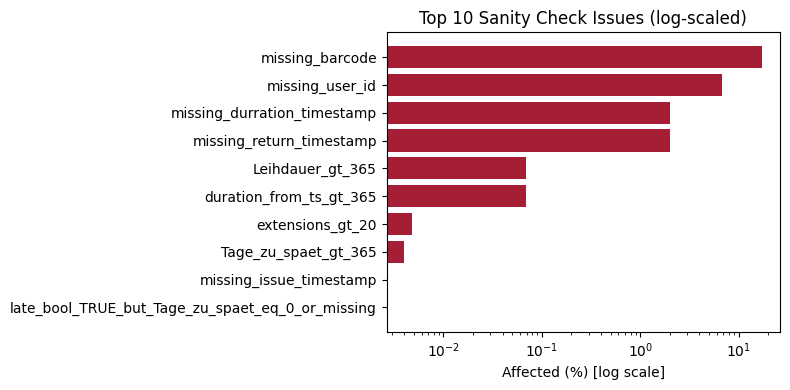

In [77]:
# --- summarize issues ---

# table of issues
issues_df = pd.DataFrame(issues).sort_values("affected_rows", ascending=False).reset_index(drop=True)
display(issues_df)

print("Total rows:", len(borrowings))
print("Checks run:", len(issues_df))

# plot top 10 issues
top = issues_df.head(10).iloc[::-1]

plt.figure(figsize=(8, 4))
plt.barh(top["check"], top["affected_pct"])
plt.xscale("log")
plt.xlabel("Affected (%) [log scale]")
plt.title("Top 10 Sanity Check Issues (log-scaled)")
plt.tight_layout()
plt.show()



## Sanity Check Summary

- Number of checks performed: **18**
- Most frequent issues: **missing_barcode (17.33%); missing_user_id (6,7%); missing_return_timestemp; Leihdauer_gt_365**
- Next step: cleaning rules in `03_data_cleaning.ipynb` based on these findings.


# To check: Robin :) 

In [78]:
# # Konvertierung der Datums-Spalten
# borrowings_df['Ausleihdatum/Uhrzeit'] = pd.to_datetime(borrowings_df['Ausleihdatum/Uhrzeit'], errors='coerce')
# borrowings_df['Rückgabedatum/Uhrzeit'] = pd.to_datetime(borrowings_df['Rückgabedatum/Uhrzeit'], errors='coerce')

# total_rows = len(borrowings_df)

# # Offene Ausleihen
# open_loans_mask = borrowings_df['Rückgabedatum/Uhrzeit'].isna() & borrowings_df['Ausleihdatum/Uhrzeit'].notna()
# open_loans_count = open_loans_mask.sum()

# # Zurückgegebene Ausleihen
# complete_mask = borrowings_df['Ausleihdatum/Uhrzeit'].notna() & borrowings_df['Rückgabedatum/Uhrzeit'].notna()

# # Exakte Zeitberechnung mit Auf und Abrunden je nach Zeitdifferenz
# borrowings_df.loc[complete_mask, 'Leihdauer_neu'] = np.round(
#     (borrowings_df.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - borrowings_df.loc[complete_mask, 'Ausleihdatum/Uhrzeit']).dt.total_seconds() / 86400
# ).astype(int)

# # Ändere orginal Leihdauerstrings zu numerischen Werten und speicher in neuer Spalte
# borrowings_df['Leihdauer_num'] = pd.to_numeric(borrowings_df.get('Leihdauer'), errors='coerce')

# # Vergleichsmaske: nur vollständige Datensätze mit numerischer Leihdauer
# compare_mask = complete_mask & borrowings_df['Leihdauer_num'].notna()

# # Differenz in Tagen zwischen berechneter und Leihdauer aus CSV
# borrowings_df.loc[compare_mask, 'Diff_in_Tagen'] = borrowings_df.loc[compare_mask, 'Leihdauer_neu'] - borrowings_df.loc[compare_mask, 'Leihdauer_num']

# # Zählen der Fälle mit positiver, negativer und null Differenz
# pos = (borrowings_df['Diff_in_Tagen'] > 0).sum()
# neg = (borrowings_df['Diff_in_Tagen'] < 0).sum()
# zero = (borrowings_df['Diff_in_Tagen'] == 0).sum()

# # Ausgabe der Ergebnisse
# print("=== Loan Duration ===")
# print(f"Total rows: {total_rows}")
# print(f"Returned loans: {complete_mask.sum()} ({complete_mask.sum()/total_rows:.2%})")
# print(f"Open loans: {open_loans_count} ({open_loans_count/total_rows:.2%})")

# print("\n=== Comparison: loan duration CSV vs. calculated ===")
# print(f"Comparable cases: {compare_mask.sum()}")
# print(f" - Calculated longer: {pos} ({(pos/max(compare_mask.sum(),1)):.2%})")
# print(f" - Both equal: {zero} ({(zero/max(compare_mask.sum(),1)):.2%})")
# print(f" - Calculated shorter: {neg} ({(neg/max(compare_mask.sum(),1)):.2%})")

# # Kompakte, lesbare Tabelle der Differenzen
# Diff_in_Tagen_counts = borrowings_df.loc[compare_mask, 'Diff_in_Tagen'].value_counts().sort_index()

# Diff_in_Tagen_summary = (
#     Diff_in_Tagen_counts.rename('Anzahl')
#     .to_frame()
#     .assign(Anteil=lambda x: x['Anzahl'] / max(compare_mask.sum(), 1))
#     .reset_index()
#     .rename(columns={'index': 'Differenz (berechnet - Original)'})
# )

# print("\n=== Distribution of difference ===")
# display(Diff_in_Tagen_summary.head(15).style.format({'Anteil': '{:.2%}'}))

# # Roh-Differenz für Zusatzanalysen
# delta_raw = borrowings_df.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - borrowings_df.loc[complete_mask, 'Ausleihdatum/Uhrzeit']
# zero_day = (delta_raw.dt.days == 0).sum()
# zero_exact_ts = (delta_raw.dt.total_seconds() == 0).sum()

# print("\n=== Edge Cases ===")
# print(f"Same day borrow and returns (but different times): {zero_day}")
# print(f"Exactly identical timestamp for borrowing and returning: {zero_exact_ts}")


# # Prüfung auf negative Zeitdifferenzen (Datenfehler) im Datensatz
# negative_mask = delta_raw.dt.total_seconds() < 0
# negative_count = negative_mask.sum()

# print("\n=== Data Quality Check ===")
# print(f"Negative time differences (data errors): {negative_count}")

# # Gibt Beispiele für negative Zeitdifferenzen aus, falls vorhanden
# if negative_count > 0:
#     neg_examples = borrowings_df.loc[complete_mask].loc[negative_mask, [
#         'Ausleihdatum/Uhrzeit','Rückgabedatum/Uhrzeit','Leihdauer_num','Leihdauer_neu','Diff_in_Tagen'
#     ]].head(15)
#     print("\nExamples of negative cases (sample):")
#     display(neg_examples)

In [79]:
# print("\n=== Duplicate Rows Check ===")

# # Komplett identische Zeilen
# duplicate_count = borrowings_df.duplicated().sum()
# print(f"Number of complete duplicate rows: {duplicate_count}")

# # dentische Ausleihe- und Rückgabezeiten
# exact_timestamp_duplicates = borrowings_df.duplicated(subset=['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit'])
# exact_timestamp_count = exact_timestamp_duplicates.sum()
# print(f"Rows with identical borrow and return timestamps: {exact_timestamp_count}")

# #if exact_timestamp_count > 0:
# #    print("\nExamples of exact timestamp duplicates:")
# #    display(borrowings_df.loc[exact_timestamp_duplicates, [
# #        'Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Leihdauer', 'Benutzer-Systemnummer'
# #    ]].head(5))

# # Identische Zeitstempel + gleicher Benutzer
# exact_user_timestamp_duplicates = borrowings_df.duplicated(
#     subset=['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer']
# )
# exact_user_timestamp_count = exact_user_timestamp_duplicates.sum()
# print(f"\nRows with identical borrow and return timestamps and same user: {exact_user_timestamp_count}")

# if exact_user_timestamp_count > 0:
#     print("\nExamples (same user, same timestamps):")
#     # Zeige alle Duplikate (einschließlich der ersten Instanz) und sortiere nach den Timestamps
#     duplicates = borrowings_df[borrowings_df.duplicated(subset=['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer'], keep=False)]
#     display(duplicates.sort_values(['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer'])[[
#         'Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer'
#     ]].head(10))

# # Identische Zeitstempel aber verschiedene Benutzer
# timestamp_user_stats = borrowings_df.groupby(['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit']).agg({
#     'Benutzer-Systemnummer': 'nunique'
# }).rename(columns={'Benutzer-Systemnummer': 'unique_users'})

# multi_user_timestamps = (timestamp_user_stats['unique_users'] > 1).sum()
# print(f"\nSame borrow and return timestamps with different users_ID: {multi_user_timestamps}")

# # Gleiche Ausleihe-Zeit (ohne Rückgabe) aber verschiedene Benutzer
# issue_time_stats = borrowings_df.groupby('Ausleihdatum/Uhrzeit').agg({
#     'Benutzer-Systemnummer': 'nunique'
# }).rename(columns={
#     'Benutzer-Systemnummer': 'unique_users'
# })

# multi_user_issue_times = issue_time_stats[issue_time_stats['unique_users'] > 1]
# print(f"\nSame borrow times with different users_ID: {len(multi_user_issue_times)}")

# if len(multi_user_issue_times) > 0:
#     print("\nExamples of same borrow time with different users:")
#     example_times = multi_user_issue_times.head(3).index
#     examples = borrowings_df[borrowings_df['Ausleihdatum/Uhrzeit'].isin(example_times)].sort_values(
#         ['Ausleihdatum/Uhrzeit', 'Benutzer-Systemnummer']
#     )[['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer', 'Barcode']].head(5)
#     display(examples)

# # Gemeinsame Ausleihe-Zeit + gleicher Benutzer aber mehrere Medien
# same_user_same_time = borrowings_df.groupby(['Ausleihdatum/Uhrzeit', 'Benutzer-Systemnummer']).size()
# multi_item_checkouts = (same_user_same_time > 1).sum()
# print(f"Cases where one user checked out multiple items at exact same time: {multi_item_checkouts}")

# if multi_item_checkouts > 0:
#     max_simultaneous = same_user_same_time.max()
#     print(f"Maximum items checked out simultaneously by one user: {max_simultaneous}")

In [80]:
# # Analyse der Gruppen mit gleichen Timestamps
# print("\n=== Analysis of Timestamp Groups ===")

# # Gruppengrößen für Timestamp-Duplikate (gleiche Ausleih- und Rückgabezeiten)
# timestamp_groups = borrowings_df.groupby(['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit']).size()
# groups_with_duplicates = timestamp_groups[timestamp_groups > 1]

# print(f"Number of groups with duplicate timestamps (same borrow and return times): {len(groups_with_duplicates)}")
# print(f"Largest group size: {groups_with_duplicates.max()}")

# # Zeige die Top-5 größten Gruppen
# print("\nTop 5 largest groups (by number of rows with same timestamps):")
# display(groups_with_duplicates.nlargest(5).to_frame('group_size').reset_index())

# # Für die Gruppe mit verschiedenen Benutzern
# multi_user_groups = timestamp_user_stats[timestamp_user_stats['unique_users'] > 1]
# print(f"\nGroups with different users (same timestamps, different user IDs): {len(multi_user_groups)}")
# if len(multi_user_groups) > 0:
#     print("Details of the group(s) with different users:")
#     display(multi_user_groups.reset_index())